In [1]:
import numpy as np
import librosa as lb

import os, time

from src.core.lstm import BiLSTM
from src.core.layers import Linear, SigmoidActivation
from src.core.loss import MSELoss
from src.core.optimizers import Adam
from src.core.cosine_scheduler import CosineScheduler
from src.projects.voice_enhancement.fourier_transform import compute_stft, compute_stft_inv, convert_to_db, filter_downsample, plot_spectrogram
from src.utils.save_and_load_model import save_model, load_model
from src.utils.save_and_load_checkpoint import save_checkpoint, load_checkpoint

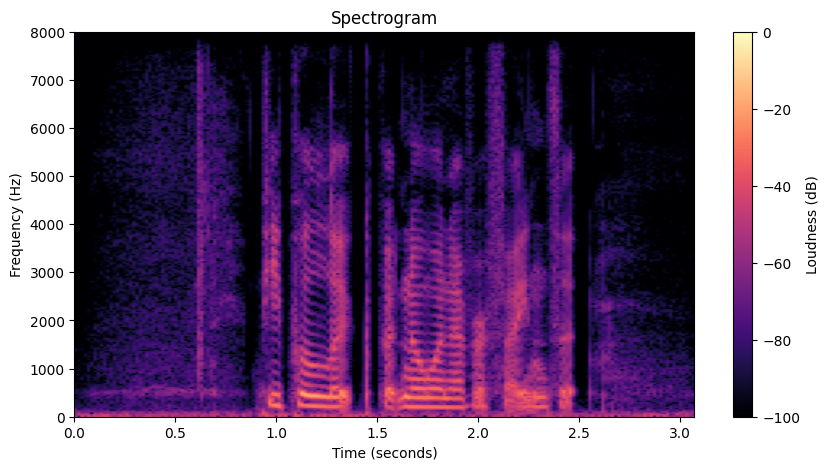

In [4]:
sample_path = r"C:\Datasets\Clean and Noisy Audio Dataset 16kHz\train\clean\p234_010.wav"
# We already preprocessed the audios to 16kHz

audio, sr_orig = lb.load(sample_path, sr=None)

N = 512
hop = 256

spectrogram, orig_len = compute_stft(audio, N=N, hop=hop)

plot_spectrogram(spectrogram, sr_orig, hop, N)

In [ ]:
# Our idea for training the model: We have our audio. We turn it into a spectrogram, of shape (B, num_frames, bins)
# We feed the LSTM just np.abs(spectrogram) scaled to decibels
# We store the magnitude and the phase. We need it to reconstruct it later.
# LSTM masks the magnitudes, then we just do clean_magnitude * np.exp(1j * phase) to correctly scale and rotate back to complex plane.
# Then we convert new spectrogram back to audio

# Basically: Input a spectrogram, output a mask. 

# Pipeline is: BiLSTM -> Linear -> Sigmoid -> MSELoss(pred, real mask)

# We train on only 2s chunks. We can infer on 60s tho - if we chopped it up, the bidirectional LSTM wouldnt really look into the future - it would be lobotomised every say, 2s of audio being cleaned.
# Also the memory probably wont run out, because we dont do backward pass.

In [ ]:
class VoiceDataset:
    def __init__(self, path, duration, sr, N, hop, batch_size):
        self.duration = duration
        self.sr = sr
        self.N = N
        self.hop = hop
        self.batch_size = batch_size
        
        self.train_split = []
        self.test_split = []
        
        self.num_batches = {
            "train" : None,
            "test" : None
        }
        
        for split in ['train', 'test']:
            clean_dir_path = os.path.join(path, split, 'clean')
            noisy_dir_path = os.path.join(path, split, 'noisy')
            
            # We know the names are the same in both directories, same amount of files
            clean_files = sorted(os.listdir(clean_dir_path))
            noisy_files = sorted(os.listdir(noisy_dir_path))
            
            self.num_batches[split] = len(clean_files) // batch_size
            
            for batch_index in range(self.num_batches[split]):
                start = batch_index * batch_size
                end = start + batch_size
                
                batch_paths = []
                for i in range(start, end):
                    c_path = os.path.join(clean_dir_path, clean_files[i])
                    n_path = os.path.join(noisy_dir_path, noisy_files[i])
                    
                    batch_paths.append((c_path, n_path))
                    
                if split == "train":
                    self.train_split.append(batch_paths)
                elif split == 'test':
                    self.test_split.append(batch_paths)
                    
    def get_batch(self, split='train', index=0):
        if split == 'train':
            batch_list = self.train_split[index]
        elif split == 'test':
            batch_list = self.test_split[index]
            
        X_batch, Y_batch = [], []
        
        target_samples = int(self.sr * self.duration)
            
        for clean_path, noisy_path in batch_list:
            c_audio, _ = lb.load(clean_path, sr=self.sr)
            n_audio, _ = lb.load(noisy_path, sr=self.sr)
            
            if len(c_audio) > target_samples:
                start = np.random.randint(0, len(audio) - target_samples)
                c_audio = c_audio[start: start + target_samples]
                n_audio = n_audio[start: start + target_samples]
        
            else: 
                c_audio = np.pad(c_audio, (0, target_samples - len(c_audio)))
                n_audio = np.pad(n_audio, (0, target_samples - len(n_audio)))
                
            c_spec = compute_stft(c_audio, self.N, self.hop)
            n_spec = compute_stft(n_audio, self.N, self.hop)
            
            c_mag = np.abs(c_spec)
            n_mag = np.abs(n_spec)
            
            x_input = convert_to_db(n_spec, self.N)
            
            mask = c_mag / (n_mag + 1e-9) # target_mask = np.abs(clean) / np.abs(noisy) -> this means "how much of clean signal is in the noisy?" If its 100% then its 1, if 0% then 0.
            mask = np.clip(mask, 0, 1, mask)
            
            X_batch.append(x_input)
            Y_batch.append(mask)
            
        return X_batch, Y_batch

In [ ]:
dataset_path = r"C:\Datasets\Clean and Noisy Audio Dataset 16kHz"
duration = 2 # 2 sec per sample, if less we pad
sampling_rate = 16000
N, hop = 512, 256
batch_size = 32

input_dim = N // 2 + 1 # amount of bins
hidden_dim = 256
output_dim = N // 2 + 1 # also amount of bins (the mask)

max_lr = 1e-4
min_lr = 1e-5
warmup_epochs = 5
total_epochs = 20

dataset = VoiceDataset(dataset_path, sampling_rate, duration, N, hop, batch_size)
model = BiLSTM(input_dim, hidden_dim, output_dim)
head = Linear(2 * hidden_dim, output_dim) # 2 x hidden because its Bidirectional LSTM
head_act = SigmoidActivation()
loss_fn = MSELoss()
params = model.params() + head.params()
optimizer = Adam(params, max_lr, beta1=0.9, beta2=0.999, eps=1e-8)
scheduler = CosineScheduler(max_lr, min_lr, warmup_epochs, total_epochs)

loss_history = []
best_loss = float('inf')

learnable_layers = {
    "BiLSTM" : model,
    "Head" : head
}

for epoch in range(1, total_epochs+1):
    learning_rate = scheduler.get_lr(epoch)
    
    for batch_index in range(dataset.num_batches['train']):
        start_time = time.time()
        
        X_batch, Y_batch = dataset.get_batch('train', batch_index)

        hidden_states = model.forward(X_batch, init_f_states=None, init_b_states=None) # (B, num_frames, 2 * hidden_dim)
        logits = head.forward(hidden_states) # (B, num_frames, output_dim)
        mask = head_act.forward(logits)
        loss = loss_fn.forward(mask, Y_batch) 
        
        loss_history.append(loss)
        
        dmask = loss_fn.backward()
        dlogits = head_act.backward(dmask)
        dhidden_states = head.backward(dlogits)
        dinput = model.backward(dhidden_states)
        
        optimizer.step(learning_rate)
        
        end_time = time.time()
        diff = end_time - start_time
        
        if batch_index % 100 == 0:
            print(f"Epoch: {epoch} | Batch: {batch_index+1} | Loss: {loss} | Time per batch: {diff:.2f}s")
            
    print(f"Finished epoch {epoch}. Loss: {loss}")
        
    if loss < best_loss:
        best_loss = loss
        save_checkpoint('models/checkpoint_best_noice_reduction', learnable_layers, optimizer)       

In [ ]:
def clean_recording(path):
    pass